# Modeling

This notebook builds several classification models to predict a repeated suicide attempt. We first start with fitting baseline models and then work to improve them.

In [2]:
# import libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import functions as func

from scipy import interp
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV

from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix

## Baseline models

To get a sense of where we're starting at, we built a baseline logistic regression and decision tree model. Logistic regression is a fast, scalable, and interpretable model that learns a linear decision boundary for binary (and multinomial) classification tasks, while a decision tree is an intuitive and expressive model that can learn complex non-linear decision boundaries. Because the cost of a false negative (i.e., misclassifying a veteran as unlikely to have a repeated suicide attempt) is high, we focus on using recall to assess model performance. However, given that a  false positive (i.e., misclassifying a veteran as likely to have a repeated suicide attempt) can instigate a lot of mental and emotional distress, we keep an eye on precision to make sure it's not too low.

The baseline models show poor results. Although accuracy is fairly high (~80%), both recall and precision are 0. It seems like the models predicted that each example had the majority class (label 0) :/ Based on our EDA, this is probably because of the imbalance between the labels. 

In [24]:
# load data
df = pd.read_csv('~/Desktop/repeat_suicide_attempt_cleaned_test.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7679 entries, 0 to 7678
Data columns (total 67 columns):
repeat_attempt_within_oneyear    7679 non-null int64
alcohol_com_new                  7679 non-null int64
anxiety_com_new                  7679 non-null int64
anydem_com_new                   7679 non-null int64
bipolar_com_new                  7679 non-null int64
cancer_com_new                   7679 non-null int64
cerebrovascular_com_new          7679 non-null int64
chf_com_new                      7679 non-null int64
chronicpain_com_new              7679 non-null int64
circulatory_com_new              7679 non-null int64
copd_com_new                     7679 non-null int64
csrdtbi_com_new                  7679 non-null int64
csrdtbi_mild_com_new             7679 non-null int64
csrdtbi_mod_com_new              7679 non-null int64
depnos_com_new                   7679 non-null int64
depression_com_new               7679 non-null int64
dm_com_new                       7679 non-nul

In [20]:
df.head()

,repeat_attempt_within_oneyear,alcohol_com_new,anxiety_com_new,anydem_com_new,bipolar_com_new,cancer_com_new,cerebrovascular_com_new,chf_com_new,chronicpain_com_new,circulatory_com_new,...,income_3digit,education_3digit,age_group_cat2,gender,race_csrd_4cat,race_csrd_4cat_v2,race_csrd_3cat,ms_csrd_5cat,ms_csrd_2cat,ms_csrd_7cat
0,1,0,0,0,0,0,0,0,0,0,...,1.0,0.0,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,...,2.0,1.0,1,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0,0,0,1,...,2.0,0.0,1,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,1,1,1,1,1,3,0,6
4,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,2,1,1,1,1,2,0,3


In [21]:
# split train, test set 
x = df.loc[:, feats]
y = df['repeat_attempt_within_oneyear']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, shuffle = True, random_state = 42)
print('train set size: {x}, {y}'.format(x = x_train.shape, y = y_train.shape)) 
print('test set size: {x}, {y}'.format(x = x_test.shape, y = y_test.shape))

train set size: (6143, 52), (6143,)
test set size: (1536, 52), (1536,)


In [22]:
# baseline pipelines
pipe_lr = Pipeline([('scaler', StandardScaler()), 
                    ('clf', LogisticRegression(penalty = 'l2', random_state = 10))])
pipe_dt = Pipeline([('clf', DecisionTreeClassifier(criterion = 'entropy', random_state = 10))])

baseline_pipes = [pipe_lr, pipe_dt]

In [23]:
# holdout cross validation
names = ['logistic regression', 'decision tree']
for i, p in enumerate(baseline_pipes):
    print(names[i])
    p.fit(x_train, y_train)
    func.get_metrics(p, x_test, y_test)
    print('\n')

logistic regression
accuracy: 0.853
recall: 0.0
precision: 0.0
f1: 0.0
roc auc: 0.5
classification report:
             precision    recall  f1-score   support

          0       0.85      1.00      0.92      1310
          1       0.00      0.00      0.00       226

avg / total       0.73      0.85      0.79      1536

confusion matrix:
[[1310    0]
 [ 226    0]]


decision tree
accuracy: 0.756
recall: 0.08
precision: 0.097
f1: 0.088
roc auc: 0.476
classification report:
             precision    recall  f1-score   support

          0       0.85      0.87      0.86      1310
          1       0.10      0.08      0.09       226

avg / total       0.74      0.76      0.75      1536

confusion matrix:
[[1143  167]
 [ 208   18]]




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Better models 

To address the imbalance between the labels, we undersampled the majority class without replacement to achieve an equal balance with the minority class (and to avoid computational issues that may arise from working on an office machine with 8GB RAM...). We also excluded redundant features, one-hot encoded categorial variables like race-ethnicity and marital status (to account for the possiblity that different categories could have different effects on the outcome), included new features, checked for feature collinearity, performed feature selection with embedded methods to remove unimportant features, and implemented k-fold cross validation to get a more robust and reliable estimate of model performance. Unlike linear models, because tree-based models perform implicit feature selection and don't really handle explicit interactions, we separated this process for linear and tree-based models. 

Generally, these models performed much better than the baseline models. Logistic regression produced the best results, with the highest recall of roughly 72% and higher precision of around 60%. Although recall gradually improved, precision consistently hovered at around 60% with little improvement. These results suggest that the dataset is likely missing features that are important for predicting a repeated suicide attempt.

In [3]:
# load data 
df = pd.read_csv('~/Desktop/repeat_suicide_attempt_updated.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7679 entries, 0 to 7678
Data columns (total 92 columns):
repeat_attempt_within_oneyear    7679 non-null int64
alcohol_com_new                  7679 non-null int64
anxiety_com_new                  7679 non-null int64
anydem_com_new                   7679 non-null int64
bipolar_com_new                  7679 non-null int64
cancer_com_new                   7679 non-null int64
cerebrovascular_com_new          7679 non-null int64
chf_com_new                      7679 non-null int64
chronicpain_com_new              7679 non-null int64
circulatory_com_new              7679 non-null int64
copd_com_new                     7679 non-null int64
csrdtbi_com_new                  7679 non-null int64
csrdtbi_mild_com_new             7679 non-null int64
csrdtbi_mod_com_new              7679 non-null int64
depnos_com_new                   7679 non-null int64
depression_com_new               7679 non-null int64
dm_com_new                       7679 non-nul

In [4]:
# balance labels 
neg_label_df = df[df['repeat_attempt_within_oneyear'] == 0]
pos_label_df = df[df['repeat_attempt_within_oneyear'] == 1]

resampled_neg_label_df = neg_label_df.sample(pos_label_df.shape[0], replace = False)
balanced_df = pd.concat([resampled_neg_label_df, pos_label_df], axis = 0)

balanced_df.shape

(2236, 92)

In [29]:
# exclude features
exclude_feats = ['age_group_cat2', 'race_csrd_4cat', 'race_csrd', 'race_csrd_4cat_v2', 'ms_csrd_7cat', 
                 'ms_csrd_2cat', 'num_disorders', 'yes_disorders', 'yes_psych_disorders',
                 'yes_med_disorders',  'repeat_attempt_within_oneyear', 'mooddis_com_new', 'anxiety_com_new', 
                 'substance_com_new', 'csrdtbi_com_new', 'hepatitis_com_new', 'pain_com_new', 'circulatory_com_new', 
                 'sleep_anydis_com_new', 'depression_com_new', 'num_mood_disorders', 'num_anxiety_disorders', 
                 'num_psychotic_disorders', 'num_substance_disorders']

interaction_feats = list(filter(lambda col: 'income' in col and 'ms' in col, balanced_df.columns))

In [30]:
# one-hot encode categorial features for logistic regression
encoded_feats = list(balanced_df.columns.difference(exclude_feats))
y = balanced_df['repeat_attempt_within_oneyear']

encoded_x = pd.get_dummies(balanced_df.loc[:, encoded_feats], 
                           columns = ['race_csrd_3cat', 'ms_csrd_5cat', 'income_3digit'])
print('features for linear models: {feats}'.format(feats = encoded_x.columns))

# non-encoded features for tree-based models
feats = list(balanced_df.columns.difference(exclude_feats + interaction_feats))
x = balanced_df.loc[:, feats]
print('features for tree-based models: {feats}'.format(feats = x.columns))

features for linear models: Index(['age_index', 'alcohol_com_new', 'any_homeless_bl', 'anydem_com_new',
       'bipolar_com_new', 'cancer_com_new', 'cerebrovascular_com_new',
       'chf_com_new', 'chronicpain_com_new', 'copd_com_new',
       'csrdtbi_mild_com_new', 'csrdtbi_mod_com_new', 'depnos_com_new',
       'dm_com_new', 'drug_com_new', 'dys_com_new', 'education_3digit',
       'epilepsy_com_new', 'gad_com_new', 'gastrointestinal_com_new', 'gender',
       'hepa_com_new', 'hepb_com_new', 'hepc_com_new', 'hiv_com_new',
       'hyperten_com_new', 'income_1.0_ms_1', 'income_1.0_ms_2',
       'income_1.0_ms_3', 'income_1.0_ms_4', 'income_1.0_ms_5',
       'income_2.0_ms_1', 'income_2.0_ms_2', 'income_2.0_ms_3',
       'income_2.0_ms_4', 'income_2.0_ms_5', 'income_3.0_ms_1',
       'income_3.0_ms_2', 'income_3.0_ms_3', 'income_3.0_ms_4',
       'income_3.0_ms_5', 'liverdis_com_new', 'major_dep_com_new',
       'mental_service_bl', 'mi_com_new', 'ms_com_new', 'num_med_disorders',
     

In [31]:
# split train, test set 
encoded_x_train, encoded_x_test, encoded_y_train, encoded_y_test = train_test_split(encoded_x, y, test_size = .2, 
                                                                                   shuffle = True, random_state = 42)
print('encoded train set size: {x}, {y}'.format(x = encoded_x_train.shape, y = encoded_y_train.shape)) 
print('encoded test set size: {x}, {y}'.format(x = encoded_x_test.shape, y = encoded_y_test.shape))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, shuffle = True, random_state = 42)
print('train set size: {x}, {y}'.format(x = x_train.shape, y = y_train.shape))
print('test set size: {x}, {y}'.format( x = x_test.shape, y = y_test.shape))

encoded train set size: (1788, 76), (1788,)
encoded test set size: (448, 76), (448,)
train set size: (1788, 53), (1788,)
test set size: (448, 53), (448,)


In [32]:
# check feature collinearity
x_train.corr().style.background_gradient()

In [33]:
# create pipelines
pipe_lr = Pipeline([('scaler', StandardScaler()),
                    ('feat_select_var', VarianceThreshold(.001)),
                    ('feat_selection', SelectFromModel(LogisticRegression(penalty = 'l1', random_state = 10))),
                    #('feat_selection', SelectFromModel(RandomForestClassifier(n_estimators = 10, criterion = 'entropy'))), 
                    #('feat_selection', SelectFromModel(ExtraTreesClassifier(n_estimators = 10, criterion = 'entropy'))), 
                    #('feat_selection', RFECV(LogisticRegression(penalty = 'l1'), cv = 10, scoring = 'recall')), 
                    ('clf', LogisticRegression(penalty = 'l2', random_state = 10))])
pipe_dt = Pipeline([('clf', DecisionTreeClassifier(criterion = 'entropy', random_state = 10))])
pipe_rf = Pipeline([('clf', RandomForestClassifier(criterion = 'entropy', random_state = 10))])
pipe_ab = Pipeline([('clf', AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1), random_state = 10))])

# pipelines for linear models 
linear_pipes = [pipe_lr]

# pipelines for tree-based models
tree_pipes = [pipe_dt, pipe_rf, pipe_ab]

logistic regression


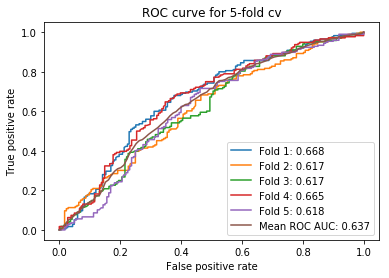

logistic regression
recall: 0.715
precision: 0.596
f1: 0.65
roc auc: 0.637


decision tree


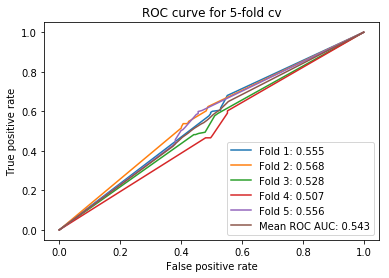

random forest


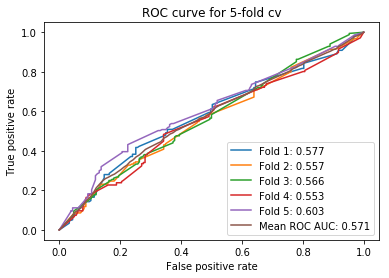

adaboost


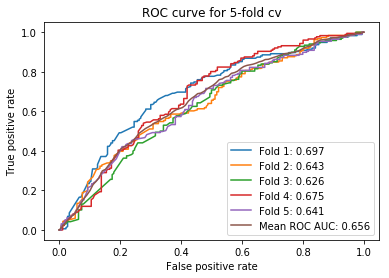

adaboost
recall: 0.685
precision: 0.605
f1: 0.642
roc auc: 0.656


decision tree
recall: 0.531
precision: 0.535
f1: 0.531
roc auc: 0.543


random forest
recall: 0.489
precision: 0.575
f1: 0.528
roc auc: 0.571




In [34]:
# run pipelines 
linear_names = ['logistic regression']
linear_results = func.format_results(func.run_pipe(linear_pipes, encoded_x_train, encoded_y_train, linear_names))

tree_names = ['decision tree', 'random forest', 'adaboost']
tree_results = func.format_results(func.run_pipe(tree_pipes, x_train, y_train, tree_names))

## Next steps

Predicting a repeated suicide attempt from EHR data is tricky! Because all the veterans already had a prior suicide attempt and EHR data primarily contains medical-related information (a limitation?), the feature representations largely look similar. As a result, our current set of features isn't sufficient enough to adequately predict a repeated suicide attempt. At this stage of the project, it seems that it's less about the algorithms and much more about the features that we have (or don't have) to capture the outcome.  

To improve the models, creativity is needed to come up with features that are not only available in EHRs but also get at other factors that are often essential to assessing suicide risk. Through reading about veteran suicides, talking to healthcare providers who work closely with veterans, and trying to put myself in a patient's shoes, I believe that more features about the severity of psychiatric and medical disorders and quality of their social environments (e.g., feeling lonely or isolated) would be extremely important to consider. Specifically, the features can include: 1) whether the patient was getting therapy (or some form of help) and the number of therapy sessions (more sessions may indicate more severe conditions), 2) whether the patient was prescribed medications and the number of medications that were prescribed, and 3) the duration and dosage of medications prescribed and actually taken (more medications and/or higher doses of them may also indicate more severe states). 

At the time of this writing, we're in the process of getting these features. Stay tuned!